### STEP 1: SETUP & IMPORTS

In [ ]:
import os
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization

!git clone https://github.com/Sarujan003/DL_Datasets.git


Cloning into 'DL_Datasets'...
remote: Enumerating objects: 8093, done.
remote: Total 8093 (delta 0), reused 0 (delta 0), pack-reused 8093 (from 1)
Receiving objects: 100% (8093/8093), 99.44 MiB | 40.09 MiB/s, done.


In [ ]:
# Load captions
caption_path = "DL_Datasets/captions.txt"
captions_df = pd.read_csv(caption_path)

image_dir = "DL_Datasets/compressed_images"

### STEP 2: LOAD CAPTIONS

In [ ]:
# Load SpaCy model
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

# Load captions
caption_path = "DL_Datasets/captions.txt"
captions_df = pd.read_csv(caption_path)

# Extract nouns and verbs for each image
keywords_dict = {}
for image, group in tqdm(captions_df.groupby("image")):
    keywords = set()
    for caption in group['caption']:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ in ["NOUN", "VERB"]:
                keywords.add(token.lemma_.lower())
    keywords_dict[image] = list(keywords)

# Create dataframe
df = pd.DataFrame(list(keywords_dict.items()), columns=["image_name", "keywords"])
df.to_csv("image_keywords.csv", index=False)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


100%|██████████| 8091/8091 [03:59<00:00, 33.75it/s]


### STEP 3: MULTI-LABEL BINARIZER

In [ ]:
mlb = MultiLabelBinarizer()
df['keywords'] = df['keywords'].apply(lambda x: list(set(x)))  # Ensure uniqueness
Y = mlb.fit_transform(df['keywords'])

# Save MultiLabelBinarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)

### STEP 4: CUSTOM DATA GENERATOR

In [ ]:
class ImageKeywordGenerator(Sequence):
    def __init__(self, df, labels, image_dir, mlb, batch_size=32, img_size=(224, 224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.mlb = mlb
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        X, Y = [], []
        for idx in batch_indexes:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.image_dir, row['image_name'])
            try:
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img) / 255.0
                X.append(img_array)
                Y.append(self.labels[idx])
            except FileNotFoundError:
                continue

        return np.array(X), np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

### STEP 5: SPLIT DATA

In [ ]:
image_dir = "DL_Datasets/compressed_images"
train_df, val_df, train_labels, val_labels = train_test_split(df, Y, test_size=0.2, random_state=42)


### STEP 6: CNN HYPERPARAMETER TUNING

In [ ]:
# Define hyperparameter configurations to test for CNN
cnn_configs = [
    # Config 1: Simple model with fewer filters
    {
        'filters': [16, 32, 64],
        'kernel_size': (3, 3),
        'dense_units': 64,
        'dropout_rate': 0.0,
        'batch_size': 32,
        'learning_rate': 0.001,
        'use_batch_norm': False
    },
    # Config 2: More filters, with dropout
    {
        'filters': [32, 64, 128],
        'kernel_size': (3, 3),
        'dense_units': 128,
        'dropout_rate': 0.3,
        'batch_size': 32,
        'learning_rate': 0.001,
        'use_batch_norm': False
    },
    # Config 3: Complex model with batch normalization
    {
        'filters': [64, 128, 256],
        'kernel_size': (3, 3),
        'dense_units': 256,
        'dropout_rate': 0.5,
        'batch_size': 16,
        'learning_rate': 0.0005,
        'use_batch_norm': True
    }
]

In [ ]:
# Function to create CNN model
def create_cnn_model(config, input_shape=(224, 224, 3), num_classes=len(mlb.classes_)):
    model = models.Sequential()

    # First Conv layer
    model.add(layers.Conv2D(config['filters'][0], config['kernel_size'], activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    if config['use_batch_norm']:
        model.add(layers.BatchNormalization())
    if config['dropout_rate'] > 0:
        model.add(layers.Dropout(config['dropout_rate']))

    # Second Conv layer
    model.add(layers.Conv2D(config['filters'][1], config['kernel_size'], activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    if config['use_batch_norm']:
        model.add(layers.BatchNormalization())
    if config['dropout_rate'] > 0:
        model.add(layers.Dropout(config['dropout_rate']))

    # Third Conv layer
    model.add(layers.Conv2D(config['filters'][2], config['kernel_size'], activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    if config['use_batch_norm']:
        model.add(layers.BatchNormalization())
    if config['dropout_rate'] > 0:
        model.add(layers.Dropout(config['dropout_rate']))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(config['dense_units'], activation='relu'))
    if config['dropout_rate'] > 0:
        model.add(layers.Dropout(config['dropout_rate']))
    model.add(layers.Dense(num_classes, activation='sigmoid'))  # Multi-label output

    from tensorflow.keras.optimizers import Adam
    model.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Train and evaluate each CNN configuration for 3 epochs
cnn_results = []

for i, config in enumerate(cnn_configs):
    print(f"\n=== Training CNN Configuration {i+1} ===")
    print(f"Configuration: {config}")

    # Create generators with the specific batch size
    train_gen = ImageKeywordGenerator(train_df, train_labels, image_dir, mlb, batch_size=config['batch_size'])
    val_gen = ImageKeywordGenerator(val_df, val_labels, image_dir, mlb, batch_size=config['batch_size'], shuffle=False)

    # Create and train model
    model = create_cnn_model(config)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=3,
        verbose=1
    )

    # Record results
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    cnn_results.append({
        'config_idx': i,
        'config': config,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    })

    # Save model checkpoint
    model.save(f"cnn_model_config_{i}.h5")

    print(f"Configuration {i+1} validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")



=== Training CNN Configuration 1 ===
Configuration: {'filters': [16, 32, 64], 'kernel_size': (3, 3), 'dense_units': 64, 'dropout_rate': 0.0, 'batch_size': 32, 'learning_rate': 0.001, 'use_batch_norm': False}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - accuracy: 0.0031 - loss: 0.1005 - val_accuracy: 0.0012 - val_loss: 0.0138
Epoch 2/3
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.0070 - loss: 0.0135 - val_accuracy: 0.0099 - val_loss: 0.0135
Epoch 3/3
203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.0173 - loss: 0.0134 - val_accuracy: 0.0247 - val_loss: 0.0133


Configuration 1 validation loss: 0.0133, validation accuracy: 0.0247

=== Training CNN Configuration 2 ===
Configuration: {'filters': [32, 64, 128], 'kernel_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.3, 'batch_size': 32, 'learning_rate': 0.001, 'use_batch_norm': False}
Epoch 1/3
203/203 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.0083 - loss: 0.1009 - val_accuracy: 0.0012 - val_loss: 0.0216
Epoch 2/3
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0076 - loss: 0.0144 - val_accuracy: 0.0012 - val_loss: 0.0154
Epoch 3/3
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.0074 - loss: 0.0140 - val_accuracy: 0.0012 - val_loss: 0.0138


Configuration 2 validation loss: 0.0138, validation accuracy: 0.0012

=== Training CNN Configuration 3 ===
Configuration: {'filters': [64, 128, 256], 'kernel_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.5, 'batch_size': 16, 'learning_rate': 0.0005, 'use_batch_norm': True}
Epoch 1/3
405/405 ━━━━━━━━━━━━━━━━━━━━ 62s 125ms/step - accuracy: 0.0080 - loss: 0.0925 - val_accuracy: 0.0148 - val_loss: 0.0234
Epoch 2/3
405/405 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.0122 - loss: 0.0176 - val_accuracy: 0.0340 - val_loss: 0.0265
Epoch 3/3
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.0175 - loss: 0.0175 - val_accuracy: 0.0303 - val_loss: 0.0246


Configuration 3 validation loss: 0.0246, validation accuracy: 0.0303


In [ ]:
# Find the best CNN configuration
best_cnn_config_idx = min(range(len(cnn_results)), key=lambda i: cnn_results[i]['val_loss'])
best_cnn_config = cnn_configs[best_cnn_config_idx]

print("\n=== Best CNN Configuration ===")
print(f"Configuration {best_cnn_config_idx + 1}: {best_cnn_config}")
print(f"Validation Loss: {cnn_results[best_cnn_config_idx]['val_loss']:.4f}")
print(f"Validation Accuracy: {cnn_results[best_cnn_config_idx]['val_accuracy']:.4f}")


=== Best CNN Configuration ===
Configuration 1: {'filters': [16, 32, 64], 'kernel_size': (3, 3), 'dense_units': 64, 'dropout_rate': 0.0, 'batch_size': 32, 'learning_rate': 0.001, 'use_batch_norm': False}
Validation Loss: 0.0133
Validation Accuracy: 0.0247


### STEP 7: TRAIN BEST CNN MODEL FOR 15 EPOCHS

In [ ]:

print("\n=== Training Best CNN Model for 15 Epochs ===")

# Create generators with the best batch size
train_gen = ImageKeywordGenerator(train_df, train_labels, image_dir, mlb, batch_size=best_cnn_config['batch_size'])
val_gen = ImageKeywordGenerator(val_df, val_labels, image_dir, mlb, batch_size=best_cnn_config['batch_size'], shuffle=False)

# Create the best model
best_cnn_model = create_cnn_model(best_cnn_config)

# Define callbacks
cnn_checkpoint = ModelCheckpoint(
    filepath='best_keyword_prediction_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train for 15 epochs
best_cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[cnn_checkpoint, early_stopping],
    verbose=1
)

# Save the final model
best_cnn_model.save("final_keyword_prediction_model.h5")



=== Training Best CNN Model for 15 Epochs ===
Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0030 - loss: 0.0925
Epoch 1: val_loss improved from inf to 0.01351, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.0030 - loss: 0.0922 - val_accuracy: 0.0012 - val_loss: 0.0135
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0088 - loss: 0.0134
Epoch 2: val_loss improved from 0.01351 to 0.01346, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.0088 - loss: 0.0134 - val_accuracy: 0.0340 - val_loss: 0.0135
Epoch 3/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0227 - loss: 0.0133
Epoch 3: val_loss improved from 0.01346 to 0.01322, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.0227 - loss: 0.0133 - val_accuracy: 0.0185 - val_loss: 0.0132
Epoch 4/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0228 - loss: 0.0131
Epoch 4: val_loss improved from 0.01322 to 0.01314, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.0228 - loss: 0.0131 - val_accuracy: 0.0216 - val_loss: 0.0131
Epoch 5/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0198 - loss: 0.0129
Epoch 5: val_loss improved from 0.01314 to 0.01306, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.0198 - loss: 0.0129 - val_accuracy: 0.0136 - val_loss: 0.0131
Epoch 6/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0222 - loss: 0.0127
Epoch 6: val_loss improved from 0.01306 to 0.01302, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.0222 - loss: 0.0127 - val_accuracy: 0.0161 - val_loss: 0.0130
Epoch 7/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0196 - loss: 0.0125
Epoch 7: val_loss improved from 0.01302 to 0.01300, saving model to best_keyword_prediction_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.0196 - loss: 0.0125 - val_accuracy: 0.0241 - val_loss: 0.0130
Epoch 8/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0249 - loss: 0.0122
Epoch 8: val_loss did not improve from 0.01300
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.0249 - loss: 0.0122 - val_accuracy: 0.0198 - val_loss: 0.0131
Epoch 9/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0287 - loss: 0.0119
Epoch 9: val_loss did not improve from 0.01300
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.0287 - loss: 0.0119 - val_accuracy: 0.0210 - val_loss: 0.0132
Epoch 10/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0292 - loss: 0.0115
Epoch 10: val_loss did not improve from 0.01300
203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.0292 - loss: 0.0115 - val_accuracy: 0.0253 - val_loss: 0.0132
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


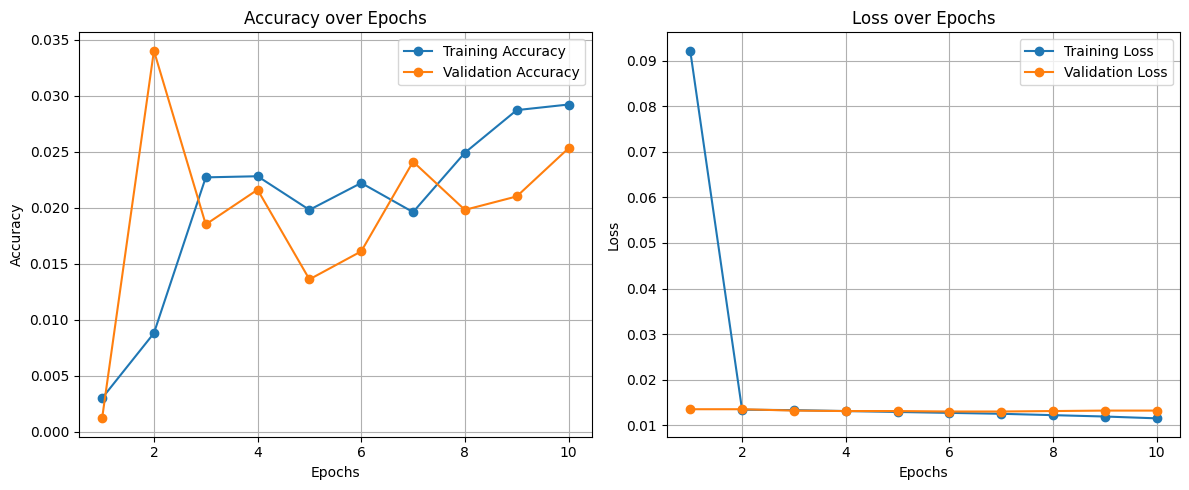

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

train_accuracy = [0.0030, 0.0088, 0.0227, 0.0228, 0.0198, 0.0222, 0.0196, 0.0249, 0.0287, 0.0292]
val_accuracy   = [0.0012, 0.0340, 0.0185, 0.0216, 0.0136, 0.0161, 0.0241, 0.0198, 0.0210, 0.0253]

train_loss = [0.0922, 0.0134, 0.0133, 0.0131, 0.0129, 0.0127, 0.0125, 0.0122, 0.0119, 0.0115]
val_loss   = [0.0135, 0.0135, 0.0132, 0.0131, 0.0131, 0.0130, 0.0130, 0.0131, 0.0132, 0.0132]

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### STEP 8: PREPARE DATA FOR CAPTION GENERATION

In [ ]:

# Load the keywords
keywords_df = pd.read_csv("image_keywords.csv")

# Load the captions
captions_df = pd.read_csv("DL_Datasets/captions.txt")

# Group captions by image
captions_grouped = captions_df.groupby('image')['caption'].apply(list).reset_index()

# Merge with keywords on image_name = image
merged_df = pd.merge(keywords_df, captions_grouped, left_on='image_name', right_on='image', how='inner')

# Drop the redundant 'image' column
merged_df.drop(columns=['image'], inplace=True)

# Expand the list of captions into separate columns
max_captions = merged_df['caption'].apply(len).max()  # max number of captions per image

for i in range(max_captions):
    merged_df[f'caption_{i+1}'] = merged_df['caption'].apply(lambda x: x[i] if i < len(x) else "")

# Drop the original 'caption' list column
merged_df.drop(columns=['caption'], inplace=True)

# Save to CSV
merged_df.to_csv("merged_image_keywords_captions.csv", index=False)


### STEP 9: PREPARE DATA FOR LSTM

In [ ]:

df = pd.read_csv("merged_image_keywords_captions.csv")

# Combine all keyword → caption pairs
data_pairs = []

for _, row in df.iterrows():
    keywords = row["keywords"]
    keywords = keywords.strip("[]").replace("'", "").split(", ")
    keyword_string = " ".join(keywords)
    for i in range(1, 6):  # 5 captions: caption_1 to caption_5
        caption_col = f"caption_{i}"
        if pd.notna(row[caption_col]) and row[caption_col].strip():
            caption = row[caption_col].strip().lower()
            data_pairs.append((keyword_string, caption))

print(f"Total samples: {len(data_pairs)}")

# Separate inputs and targets
inputs, targets = zip(*data_pairs)

# Add start/end tokens to targets BEFORE tokenizing
targets = [f"<start> {t} <end>" for t in targets]

# Tokenizers
input_tokenizer = Tokenizer(oov_token="<OOV>")
input_tokenizer.fit_on_texts(inputs)
input_sequences = input_tokenizer.texts_to_sequences(inputs)
input_maxlen = max(len(seq) for seq in input_sequences)

output_tokenizer = Tokenizer(oov_token="<OOV>")
output_tokenizer.fit_on_texts(targets)
target_sequences = output_tokenizer.texts_to_sequences(targets)
target_maxlen = max(len(seq) for seq in target_sequences)

# Pad sequences
encoder_input = pad_sequences(input_sequences, maxlen=input_maxlen, padding='post')
decoder_input = pad_sequences([seq[:-1] for seq in target_sequences], maxlen=target_maxlen-1, padding='post')
decoder_target = pad_sequences([seq[1:] for seq in target_sequences], maxlen=target_maxlen-1, padding='post')

# Vocabulary sizes
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Split data for LSTM model
train_idx, val_idx = train_test_split(range(len(encoder_input)), test_size=0.1, random_state=42)

encoder_input_train = encoder_input[train_idx]
decoder_input_train = decoder_input[train_idx]
decoder_target_train = decoder_target[train_idx]

encoder_input_val = encoder_input[val_idx]
decoder_input_val = decoder_input[val_idx]
decoder_target_val = decoder_target[val_idx]

Total samples: 40455


### STEP 10: LSTM HYPERPARAMETER TUNING

In [ ]:

# Define hyperparameter configurations to test for LSTM
lstm_configs = [
    # Config 1: Smaller model
    {
        'embedding_dim': 64,
        'lstm_units': 128,
        'dropout_rate': 0.0,
        'learning_rate': 0.001,
        'batch_size': 64
    },
    # Config 2: Medium model with dropout
    {
        'embedding_dim': 128,
        'lstm_units': 256,
        'dropout_rate': 0.3,
        'learning_rate': 0.001,
        'batch_size': 64
    },
    # Config 3: Larger model with more dropout and smaller batch size
    {
        'embedding_dim': 256,
        'lstm_units': 512,
        'dropout_rate': 0.5,
        'learning_rate': 0.0005,
        'batch_size': 32
    }
]

In [ ]:
# Function to create LSTM model
def create_lstm_model(config, input_maxlen, target_maxlen, input_vocab_size, output_vocab_size):
    # Encoder
    encoder_inputs = Input(shape=(input_maxlen,))
    encoder_emb = Embedding(input_vocab_size, config['embedding_dim'])(encoder_inputs)

    # Add dropout if specified
    if config['dropout_rate'] > 0:
        encoder_emb = Dropout(config['dropout_rate'])(encoder_emb)

    _, state_h, state_c = LSTM(config['lstm_units'], return_state=True)(encoder_emb)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(target_maxlen-1,))
    decoder_emb = Embedding(output_vocab_size, config['embedding_dim'])(decoder_inputs)

    # Add dropout if specified
    if config['dropout_rate'] > 0:
        decoder_emb = Dropout(config['dropout_rate'])(decoder_emb)

    decoder_lstm = LSTM(config['lstm_units'], return_sequences=True)(decoder_emb, initial_state=encoder_states)

    # Add dropout if specified
    if config['dropout_rate'] > 0:
        decoder_lstm = Dropout(config['dropout_rate'])(decoder_lstm)

    decoder_outputs = Dense(output_vocab_size, activation='softmax')(decoder_lstm)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    from tensorflow.keras.optimizers import Adam
    model.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Train and evaluate each LSTM configuration for 3 epochs
lstm_results = []

for i, config in enumerate(lstm_configs):
    print(f"\n=== Training LSTM Configuration {i+1} ===")
    print(f"Configuration: {config}")

    # Create and train model
    model = create_lstm_model(
        config,
        input_maxlen,
        target_maxlen,
        input_vocab_size,
        output_vocab_size
    )

    history = model.fit(
        [encoder_input_train, decoder_input_train],
        np.expand_dims(decoder_target_train, -1),
        batch_size=config['batch_size'],
        epochs=3,
        validation_data=([encoder_input_val, decoder_input_val], np.expand_dims(decoder_target_val, -1)),
        verbose=1
    )

    # Record results
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    lstm_results.append({
        'config_idx': i,
        'config': config,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    })

    # Save model checkpoint
    model.save(f"lstm_model_config_{i}.h5")

    print(f"Configuration {i+1} validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

# Find the best LSTM configuration
best_lstm_config_idx = min(range(len(lstm_results)), key=lambda i: lstm_results[i]['val_loss'])
best_lstm_config = lstm_configs[best_lstm_config_idx]

print("\n=== Best LSTM Configuration ===")
print(f"Configuration {best_lstm_config_idx + 1}: {best_lstm_config}")
print(f"Validation Loss: {lstm_results[best_lstm_config_idx]['val_loss']:.4f}")
print(f"Validation Accuracy: {lstm_results[best_lstm_config_idx]['val_accuracy']:.4f}")



=== Training LSTM Configuration 1 ===
Configuration: {'embedding_dim': 64, 'lstm_units': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.7059 - loss: 2.8715 - val_accuracy: 0.7594 - val_loss: 1.4611
Epoch 2/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7671 - loss: 1.3923 - val_accuracy: 0.7753 - val_loss: 1.2957
Epoch 3/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7818 - loss: 1.2451 - val_accuracy: 0.7869 - val_loss: 1.2023


Configuration 1 validation loss: 1.2023, validation accuracy: 0.7869

=== Training LSTM Configuration 2 ===
Configuration: {'embedding_dim': 128, 'lstm_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7188 - loss: 2.3986 - val_accuracy: 0.7678 - val_loss: 1.3532
Epoch 2/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7735 - loss: 1.3084 - val_accuracy: 0.7839 - val_loss: 1.2158
Epoch 3/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.7844 - loss: 1.1973 - val_accuracy: 0.7914 - val_loss: 1.1407


Configuration 2 validation loss: 1.1407, validation accuracy: 0.7914

=== Training LSTM Configuration 3 ===
Configuration: {'embedding_dim': 256, 'lstm_units': 512, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/3
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 60s 51ms/step - accuracy: 0.7335 - loss: 2.0019 - val_accuracy: 0.7744 - val_loss: 1.2881
Epoch 2/3
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.7798 - loss: 1.2422 - val_accuracy: 0.7905 - val_loss: 1.1452
Epoch 3/3
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.7902 - loss: 1.1304 - val_accuracy: 0.7959 - val_loss: 1.0812


Configuration 3 validation loss: 1.0812, validation accuracy: 0.7959

=== Best LSTM Configuration ===
Configuration 3: {'embedding_dim': 256, 'lstm_units': 512, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32}
Validation Loss: 1.0812
Validation Accuracy: 0.7959


### STEP 11: TRAIN BEST LSTM MODEL FOR 15 EPOCHS

In [ ]:

print("\n=== Training Best LSTM Model for 15 Epochs ===")

# Create the best model
best_lstm_model = create_lstm_model(
    best_lstm_config,
    input_maxlen,
    target_maxlen,
    input_vocab_size,
    output_vocab_size
)

# Define callbacks
lstm_checkpoint = ModelCheckpoint(
    filepath='best_caption_generator_lstm.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train for 15 epochs
best_lstm_model.fit(
    [encoder_input_train, decoder_input_train],
    np.expand_dims(decoder_target_train, -1),
    batch_size=best_lstm_config['batch_size'],
    epochs=15,
    validation_data=([encoder_input_val, decoder_input_val], np.expand_dims(decoder_target_val, -1)),
    callbacks=[lstm_checkpoint, early_stopping_lstm],
    verbose=1
)

# Save the final model
best_lstm_model.save("final_caption_generator_lstm.h5")



=== Training Best LSTM Model for 15 Epochs ===
Epoch 1/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7342 - loss: 1.9901
Epoch 1: val_loss improved from inf to 1.28091, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.7342 - loss: 1.9893 - val_accuracy: 0.7742 - val_loss: 1.2809
Epoch 2/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7796 - loss: 1.2451
Epoch 2: val_loss improved from 1.28091 to 1.15372, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.7796 - loss: 1.2451 - val_accuracy: 0.7902 - val_loss: 1.1537
Epoch 3/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7895 - loss: 1.1362
Epoch 3: val_loss improved from 1.15372 to 1.08823, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.7895 - loss: 1.1362 - val_accuracy: 0.7953 - val_loss: 1.0882
Epoch 4/15
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7961 - loss: 1.0622
Epoch 4: val_loss improved from 1.08823 to 1.01699, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - accuracy: 0.7961 - loss: 1.0622 - val_accuracy: 0.8046 - val_loss: 1.0170
Epoch 5/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8039 - loss: 0.9904
Epoch 5: val_loss improved from 1.01699 to 0.96480, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - accuracy: 0.8039 - loss: 0.9903 - val_accuracy: 0.8112 - val_loss: 0.9648
Epoch 6/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8101 - loss: 0.9329
Epoch 6: val_loss improved from 0.96480 to 0.93130, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.8101 - loss: 0.9329 - val_accuracy: 0.8149 - val_loss: 0.9313
Epoch 7/15
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8148 - loss: 0.8884
Epoch 7: val_loss improved from 0.93130 to 0.90453, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - accuracy: 0.8148 - loss: 0.8884 - val_accuracy: 0.8181 - val_loss: 0.9045
Epoch 8/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8184 - loss: 0.8533
Epoch 8: val_loss improved from 0.90453 to 0.88391, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.8184 - loss: 0.8533 - val_accuracy: 0.8213 - val_loss: 0.8839
Epoch 9/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8212 - loss: 0.8219
Epoch 9: val_loss improved from 0.88391 to 0.87008, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8212 - loss: 0.8219 - val_accuracy: 0.8232 - val_loss: 0.8701
Epoch 10/15
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8229 - loss: 0.7997
Epoch 10: val_loss improved from 0.87008 to 0.85865, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - accuracy: 0.8229 - loss: 0.7997 - val_accuracy: 0.8242 - val_loss: 0.8586
Epoch 11/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8254 - loss: 0.7760
Epoch 11: val_loss improved from 0.85865 to 0.85244, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 85s 52ms/step - accuracy: 0.8254 - loss: 0.7760 - val_accuracy: 0.8261 - val_loss: 0.8524
Epoch 12/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8289 - loss: 0.7500
Epoch 12: val_loss improved from 0.85244 to 0.84264, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - accuracy: 0.8289 - loss: 0.7500 - val_accuracy: 0.8270 - val_loss: 0.8426
Epoch 13/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8297 - loss: 0.7358
Epoch 13: val_loss improved from 0.84264 to 0.83460, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 86s 53ms/step - accuracy: 0.8297 - loss: 0.7358 - val_accuracy: 0.8282 - val_loss: 0.8346
Epoch 14/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8320 - loss: 0.7173
Epoch 14: val_loss improved from 0.83460 to 0.83036, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - accuracy: 0.8320 - loss: 0.7173 - val_accuracy: 0.8294 - val_loss: 0.8304
Epoch 15/15
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8345 - loss: 0.7000
Epoch 15: val_loss improved from 0.83036 to 0.82641, saving model to best_caption_generator_lstm.h5


1138/1138 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.8345 - loss: 0.7000 - val_accuracy: 0.8307 - val_loss: 0.8264
Restoring model weights from the end of the best epoch: 15.


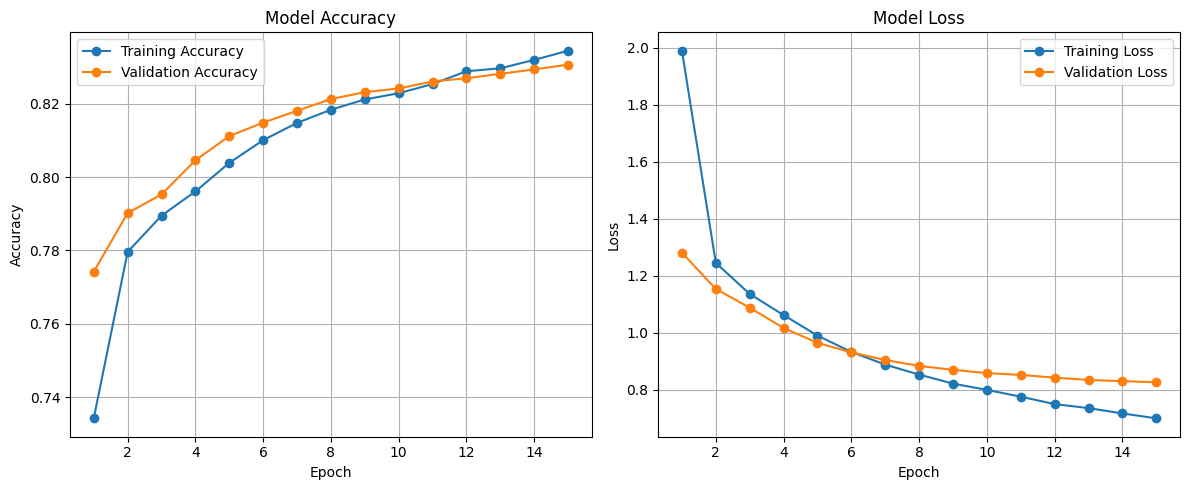

In [ ]:
import matplotlib.pyplot as plt

# Training and validation metrics per epoch
epochs = list(range(1, 16))

train_accuracy = [0.7342, 0.7796, 0.7895, 0.7961, 0.8039, 0.8101, 0.8148, 0.8184, 0.8212, 0.8229, 0.8254, 0.8289, 0.8297, 0.8320, 0.8345]
val_accuracy   = [0.7742, 0.7902, 0.7953, 0.8046, 0.8112, 0.8149, 0.8181, 0.8213, 0.8232, 0.8242, 0.8261, 0.8270, 0.8282, 0.8294, 0.8307]

train_loss = [1.9893, 1.2451, 1.1362, 1.0622, 0.9903, 0.9329, 0.8884, 0.8533, 0.8219, 0.7997, 0.7760, 0.7500, 0.7358, 0.7173, 0.7000]
val_loss   = [1.2809, 1.1537, 1.0882, 1.0170, 0.9648, 0.9313, 0.9045, 0.8839, 0.8701, 0.8586, 0.8524, 0.8426, 0.8346, 0.8304, 0.8264]

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### STEP 12: EVALUATE AND GENERATE CAPTIONS

In [ ]:

# Load the best models
best_cnn_model = load_model("best_keyword_prediction_model.h5")
best_lstm_model = load_model("best_caption_generator_lstm.h5")

# Load the MultiLabelBinarizer
with open("mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

# Function to convert a list of keywords to a string and then tokenize
def preprocess_keywords(keywords_list):
    keyword_str = " ".join(keywords_list).lower()
    sequence = input_tokenizer.texts_to_sequences([keyword_str])
    return pad_sequences(sequence, maxlen=input_maxlen, padding='post')

def generate_caption(keywords_list):
    # Convert keyword list to padded sequence
    encoder_seq = preprocess_keywords(keywords_list)

    # Use first token from training data as <start>
    start_token_id = decoder_input[0, 0]

    # Initialize decoder input
    target_seq = np.zeros((1, target_maxlen - 1))
    target_seq[0, 0] = start_token_id

    decoded_sentence = []

    for i in range(1, target_maxlen - 1):
        preds = best_lstm_model.predict([encoder_seq, target_seq], verbose=0)
        sampled_token_index = np.argmax(preds[0, i - 1, :])
        sampled_word = output_tokenizer.index_word.get(sampled_token_index, "")

        if sampled_word == "<end>" or sampled_word == "":
            break

        decoded_sentence.append(sampled_word)
        target_seq[0, i] = sampled_token_index

    return " ".join(decoded_sentence)

# Create validation generator to test models
val_gen = ImageKeywordGenerator(val_df, val_labels, image_dir, mlb, batch_size=32, shuffle=False)


In [ ]:
captions = []

In [ ]:
def generate_sentence_for_image(index_):
  # Test with different validation samples
  sample_img_batch, sample_label_batch = val_gen[index_]

  if len(sample_img_batch) > 0:
      # Pick one sample (e.g., index 0)
      sample_image = sample_img_batch[0]
      sample_label = sample_label_batch[0]

      # Predict keywords from CNN
      pred = best_cnn_model.predict(np.expand_dims(sample_image, axis=0))
      predicted_keywords = mlb.inverse_transform(pred > 0.4)

      # Take the first tuple and convert to list
      keywords_list = list(predicted_keywords[0])

      # Generate caption from predicted keywords
      caption = generate_caption(keywords_list)
      captions.append(caption)

      # Show image
      plt.figure(figsize=(6, 6))
      plt.imshow(sample_image)
      plt.axis("off")
      plt.figtext(0.5, 0.01, f"Caption: {caption}", wrap=True, horizontalalignment='center')
      plt.show()

      print(f"Sample {index_}")
      print("Generated Caption:", caption)
      print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


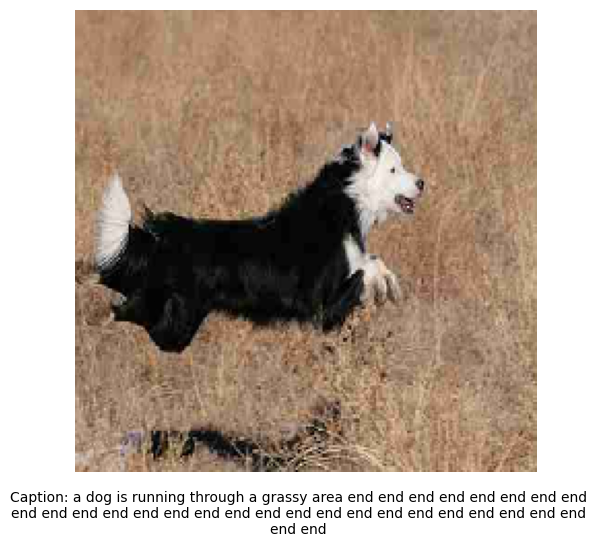

Sample 0
Generated Caption: a dog is running through a grassy area end end end end end end end end end end end end end end end end end end end end end end end end end end end end end
--------------------------------------------------


In [ ]:
generate_sentence_for_image(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


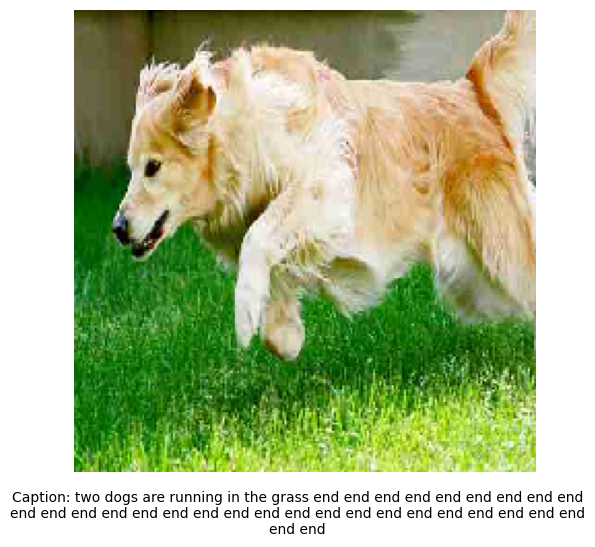

Sample 10
Generated Caption: two dogs are running in the grass end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end
--------------------------------------------------


In [ ]:
generate_sentence_for_image(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


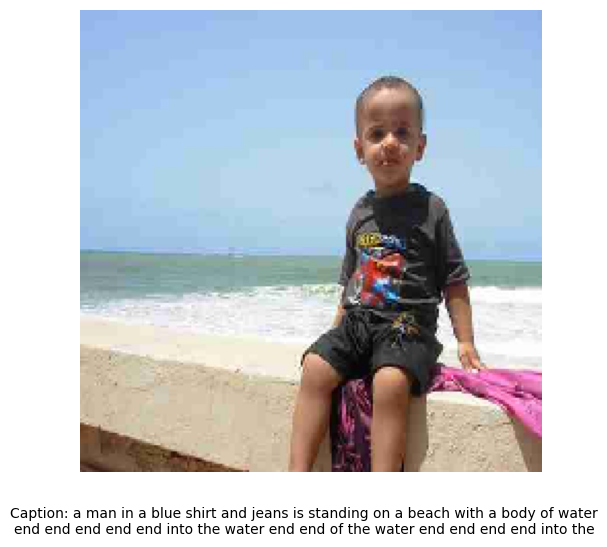

Sample 15
Generated Caption: a man in a blue shirt and jeans is standing on a beach with a body of water end end end end end into the water end end of the water end end end end into the
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


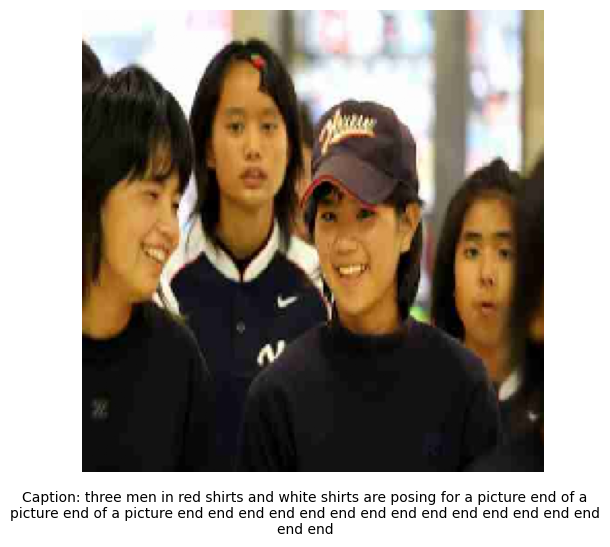

Sample 16
Generated Caption: three men in red shirts and white shirts are posing for a picture end of a picture end of a picture end end end end end end end end end end end end end end end end
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


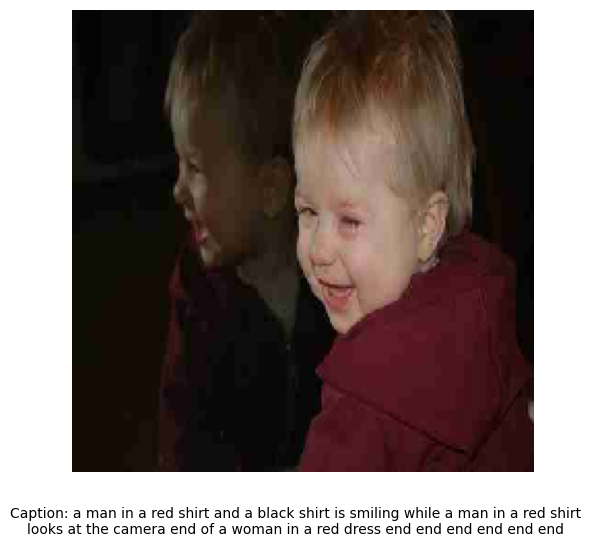

Sample 17
Generated Caption: a man in a red shirt and a black shirt is smiling while a man in a red shirt looks at the camera end of a woman in a red dress end end end end end end
--------------------------------------------------


In [ ]:
# Test with different validation samples
for sample_idx in range(14,17):
    sample_img_batch, sample_label_batch = val_gen[sample_idx]

    if len(sample_img_batch) > 0:
        # Pick one sample (e.g., index 0)
        sample_image = sample_img_batch[0]
        sample_label = sample_label_batch[0]

        # Predict keywords from CNN
        pred = best_cnn_model.predict(np.expand_dims(sample_image, axis=0))
        predicted_keywords = mlb.inverse_transform(pred > 0.1)

        # Take the first tuple and convert to list
        keywords_list = list(predicted_keywords[0])

        # Generate caption from predicted keywords
        caption = generate_caption(keywords_list)
        captions.append(caption)

        # Show image
        plt.figure(figsize=(6, 6))
        plt.imshow(sample_image)
        plt.axis("off")
        plt.figtext(0.5, 0.01, f"Caption: {caption}", wrap=True, horizontalalignment='center')
        plt.show()

        print(f"Sample {sample_idx+1}")
        print("Generated Caption:", caption)
        print("-" * 50)

In [ ]:
# Test with different validation samples
for sample_idx in range(21,30):
    sample_img_batch, sample_label_batch = val_gen[sample_idx]

    if len(sample_img_batch) > 0:
        # Pick one sample (e.g., index 0)
        sample_image = sample_img_batch[0]
        sample_label = sample_label_batch[0]

        # Predict keywords from CNN
        pred = best_cnn_model.predict(np.expand_dims(sample_image, axis=0))
        predicted_keywords = mlb.inverse_transform(pred > 0.1)

        # Take the first tuple and convert to list
        keywords_list = list(predicted_keywords[0])

        # Generate caption from predicted keywords
        caption = generate_caption(keywords_list)
        captions.append(caption)

        # Show image
        plt.figure(figsize=(6, 6))
        plt.imshow(sample_image)
        plt.axis("off")
        plt.figtext(0.5, 0.01, f"Caption: {caption}", wrap=True, horizontalalignment='center')
        plt.show()

        print(f"Sample {sample_idx+1}")
        print("Generated Caption:", caption)
        print("-" * 50)

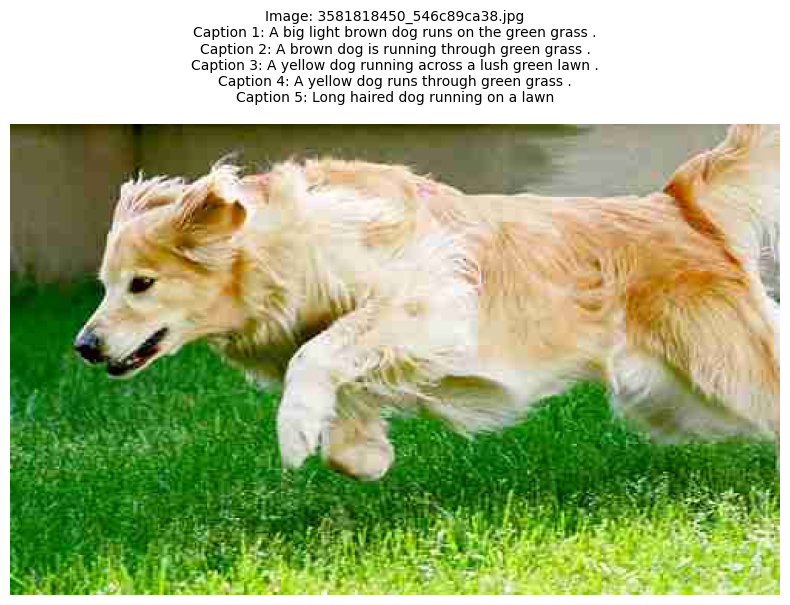


Captions for 3581818450_546c89ca38.jpg:
Caption 1: A big light brown dog runs on the green grass .
Caption 2: A brown dog is running through green grass .
Caption 3: A yellow dog running across a lush green lawn .
Caption 4: A yellow dog runs through green grass .
Caption 5: Long haired dog running on a lawn


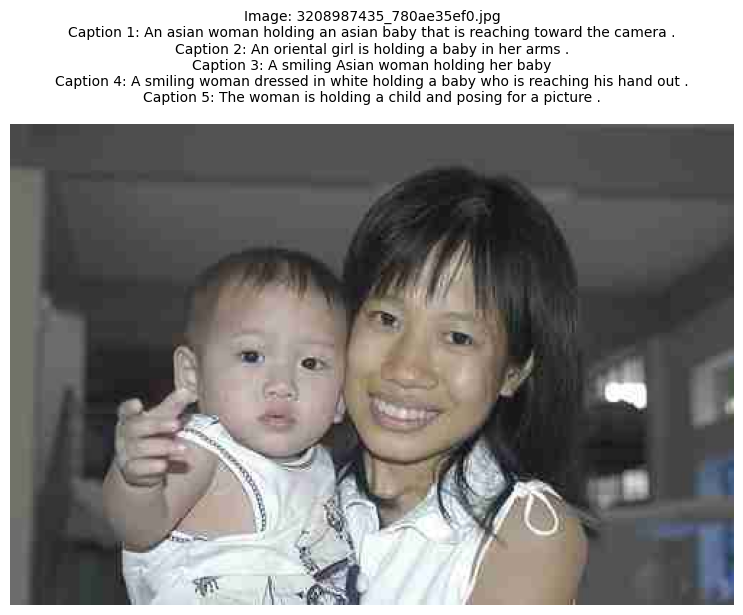


Captions for 3208987435_780ae35ef0.jpg:
Caption 1: An asian woman holding an asian baby that is reaching toward the camera .
Caption 2: An oriental girl is holding a baby in her arms .
Caption 3: A smiling Asian woman holding her baby
Caption 4: A smiling woman dressed in white holding a baby who is reaching his hand out .
Caption 5: The woman is holding a child and posing for a picture .


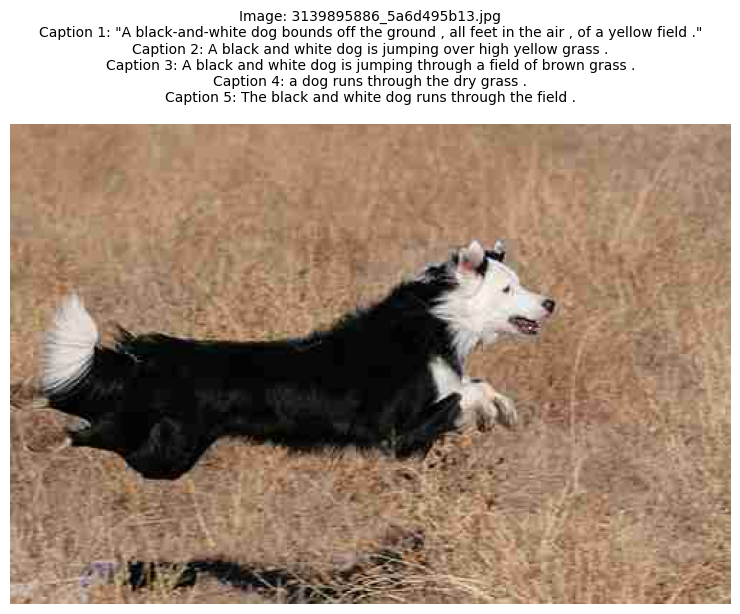


Captions for 3139895886_5a6d495b13.jpg:
Caption 1: "A black-and-white dog bounds off the ground , all feet in the air , of a yellow field ."
Caption 2: A black and white dog is jumping over high yellow grass .
Caption 3: A black and white dog is jumping through a field of brown grass .
Caption 4: a dog runs through the dry grass .
Caption 5: The black and white dog runs through the field .


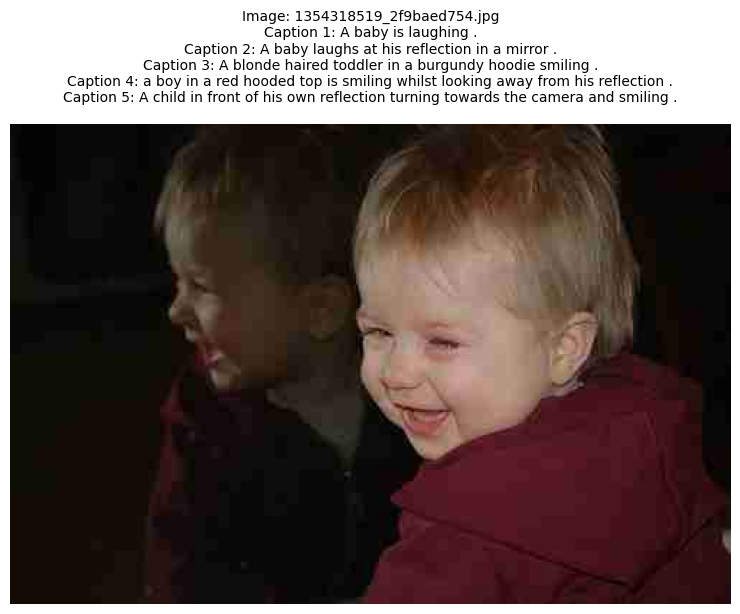


Captions for 1354318519_2f9baed754.jpg:
Caption 1: A baby is laughing .
Caption 2: A baby laughs at his reflection in a mirror .
Caption 3: A blonde haired toddler in a burgundy hoodie smiling .
Caption 4: a boy in a red hooded top is smiling whilst looking away from his reflection .
Caption 5: A child in front of his own reflection turning towards the camera and smiling .


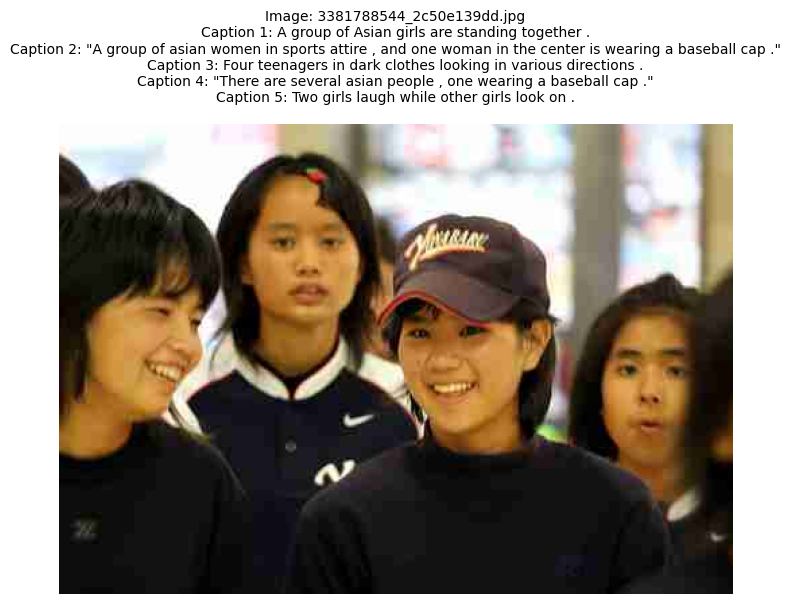


Captions for 3381788544_2c50e139dd.jpg:
Caption 1: A group of Asian girls are standing together .
Caption 2: "A group of asian women in sports attire , and one woman in the center is wearing a baseball cap ."
Caption 3: Four teenagers in dark clothes looking in various directions .
Caption 4: "There are several asian people , one wearing a baseball cap ."
Caption 5: Two girls laugh while other girls look on .


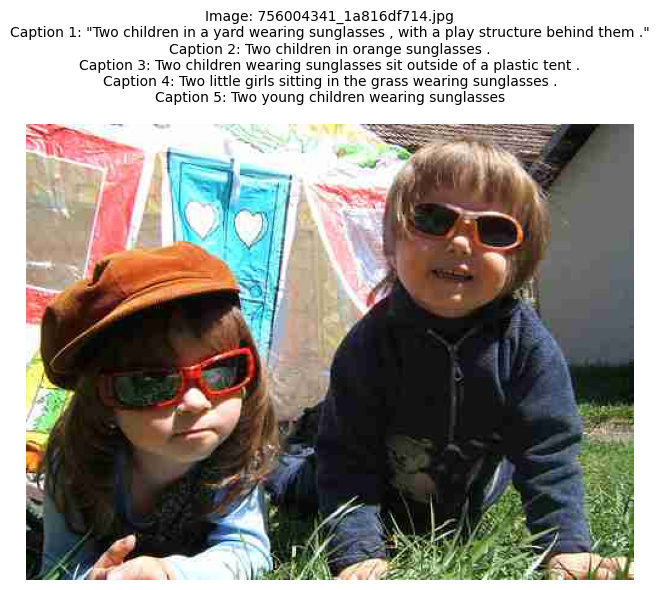


Captions for 756004341_1a816df714.jpg:
Caption 1: "Two children in a yard wearing sunglasses , with a play structure behind them ."
Caption 2: Two children in orange sunglasses .
Caption 3: Two children wearing sunglasses sit outside of a plastic tent .
Caption 4: Two little girls sitting in the grass wearing sunglasses .
Caption 5: Two young children wearing sunglasses


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the captions file
caption_path = "DL_Datasets/captions.txt"
image_dir = "DL_Datasets/compressed_images"  # Directory containing the images

# List of target images
target_images = [
    "3581818450_546c89ca38.jpg",
    "3208987435_780ae35ef0.jpg",
    "3139895886_5a6d495b13.jpg",
    "1354318519_2f9baed754.jpg",
    "3381788544_2c50e139dd.jpg",
    "756004341_1a816df714.jpg"
]

# Dictionary to store captions for each target image
image_captions = {img: [] for img in target_images}

# Open and read the file manually to avoid CSV parsing issues
with open(caption_path, 'r') as file:
    # Skip header line
    next(file)
    for line in file:
        # Parse each line, considering commas in captions
        parts = line.strip().split(',', 1)  # Split only at first comma
        if len(parts) == 2:
            image_name, caption = parts
            # Check if this image is one of our targets
            if image_name in target_images:
                image_captions[image_name].append(caption)

# Display each image with its captions
for image_name in target_images:
    # Load and display the image
    image_path = os.path.join(image_dir, image_name)
    try:
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')

        # Construct caption text
        caption_text = f"Image: {image_name}\n"
        if image_captions[image_name]:
            for i, caption in enumerate(image_captions[image_name], 1):
                caption_text += f"Caption {i}: {caption}\n"
        else:
            caption_text += "No captions found."

        plt.title(caption_text, fontsize=10, wrap=True)
        plt.tight_layout()
        plt.show()

        # Also print the captions to console
        print(f"\nCaptions for {image_name}:")
        if image_captions[image_name]:
            for i, caption in enumerate(image_captions[image_name], 1):
                print(f"Caption {i}: {caption}")
        else:
            print("No captions found.")

    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
    except Exception as e:
        print(f"Error displaying image {image_name}: {e}")

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import os
from PIL import Image

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# List of target images (in order)
target_images = [
    "3581818450_546c89ca38.jpg",
    "3208987435_780ae35ef0.jpg",
    "3139895886_5a6d495b13.jpg",
    "1354318519_2f9baed754.jpg",
    "3381788544_2c50e139dd.jpg",
    "756004341_1a816df714.jpg"
]

# The full predicted captions exactly as provided
predicted_captions = [
    "two dogs are running in the grass end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end",
    "a young girl in a blue shirt and a black dog standing in a field of a white dog end end end end end end end end end end end end end end end end end end",
    "a dog is running through a grassy area end end end end end end end end end end end end end end end end end end end end end end end end end end end end end",
    "a man in a red shirt and a black shirt is smiling while a man in a red shirt looks at the camera end of a woman in a red dress end end end end end end",
    "three men in red shirts and white shirts are posing for a picture end of a picture end of a picture end end end end end end end end end end end end end end end end",
    "two smiling people posing for a picture end of a picture end end end end end end end end end end end end end end end end end end end end end end end end end end"
]

# Path to image directory
image_dir = "DL_Datasets/compressed_images"

# Load the actual captions from the file
caption_path = "DL_Datasets/captions.txt"
reference_captions = {img: [] for img in target_images}

# Open and read the file to get reference captions
with open(caption_path, 'r') as file:
    # Skip header line
    next(file)
    for line in file:
        parts = line.strip().split(',', 1)  # Split at first comma
        if len(parts) == 2:
            image_name, caption = parts
            if image_name in target_images:
                reference_captions[image_name].append(caption.strip())

# Calculate BLEU scores for each image
smoothie = SmoothingFunction().method1  # Smoothing for short sentences
results = []

for i, image in enumerate(target_images):
    # Tokenize predicted caption (use the full caption as provided)
    predicted_tokens = nltk.word_tokenize(predicted_captions[i].lower())

    # Tokenize reference captions for this image
    references_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_captions[image]]

    # If we have reference captions, calculate BLEU score
    if references_tokens:
        # Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores
        bleu1 = sentence_bleu(references_tokens, predicted_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu(references_tokens, predicted_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu3 = sentence_bleu(references_tokens, predicted_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        bleu4 = sentence_bleu(references_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

        results.append({
            'image': image,
            'predicted': predicted_captions[i],
            'references': reference_captions[image],
            'BLEU-1': bleu1,
            'BLEU-2': bleu2,
            'BLEU-3': bleu3,
            'BLEU-4': bleu4
        })
    else:
        results.append({
            'image': image,
            'predicted': predicted_captions[i],
            'references': 'No reference captions found',
            'BLEU-1': 'N/A',
            'BLEU-2': 'N/A',
            'BLEU-3': 'N/A',
            'BLEU-4': 'N/A'
        })

# Display results with images
for result in results:
    image_name = result['image']
    image_path = os.path.join(image_dir, image_name)

    try:
        # Display the image
        img = Image.open(image_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')

        # Create title with basic information
        plt.title(f"Image: {image_name}", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Print detailed information
        print(f"\nImage: {image_name}")
        print(f"Predicted: {result['predicted']}")
        print("References:")

        if isinstance(result['references'], list):
            for i, ref in enumerate(result['references'], 1):
                print(f"  {i}. {ref}")
            print(f"BLEU-1 Score: {result['BLEU-1']:.4f}")
            print(f"BLEU-2 Score: {result['BLEU-2']:.4f}")
            print(f"BLEU-3 Score: {result['BLEU-3']:.4f}")
            print(f"BLEU-4 Score: {result['BLEU-4']:.4f}")
        else:
            print(f"  {result['references']}")

    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        print(f"BLEU scores for {image_name}:")
        if isinstance(result['BLEU-1'], float):
            print(f"BLEU-1: {result['BLEU-1']:.4f}")
            print(f"BLEU-2: {result['BLEU-2']:.4f}")
            print(f"BLEU-3: {result['BLEU-3']:.4f}")
            print(f"BLEU-4: {result['BLEU-4']:.4f}")
    except Exception as e:
        print(f"Error displaying image {image_name}: {e}")

# Calculate and display average BLEU scores
valid_results = [r for r in results if isinstance(r['BLEU-1'], float)]
if valid_results:
    avg_bleu1 = sum(r['BLEU-1'] for r in valid_results) / len(valid_results)
    avg_bleu2 = sum(r['BLEU-2'] for r in valid_results) / len(valid_results)
    avg_bleu3 = sum(r['BLEU-3'] for r in valid_results) / len(valid_results)
    avg_bleu4 = sum(r['BLEU-4'] for r in valid_results) / len(valid_results)

    print("\n===== AVERAGE BLEU SCORES =====")
    print(f"Average BLEU-1: {avg_bleu1:.4f}")
    print(f"Average BLEU-2: {avg_bleu2:.4f}")
    print(f"Average BLEU-3: {avg_bleu3:.4f}")
    print(f"Average BLEU-4: {avg_bleu4:.4f}")
else:
    print("\nNo valid BLEU scores to average.")